# Model-Agnostic Meta-Learning Training 

This script implements a Meta-Learning (MAML-Reptile) approach to train a Deep Q-Network (DQN) agent for controlling a satellite in Low Earth Orbit (LEO) environments. The goal is to develop a generalizable policy that can quickly adapt to various LEO satellite tasks, such as scanning, charging, downlinking data, and desaturating reaction wheels. It uses the Basilisk (BSK) simulation framework to model satellite dynamics and tasks, defining a custom satellite and environment with realistic orbital and hardware parameters. The script trains the agent over multiple iterations, sampling different LEO tasks (with varied orbital parameters) to learn a robust initial policy. This policy is optimized to enable few-shot adaptation to new tasks, making it efficient for scenarios where rapid learning is critical. The training progress is tracked and visualized through plots of rewards, losses, and action distributions, and the final meta-learned policy is saved for later use.

Narrative Hook for Jupyter Notebook:

"Imagine a satellite that can learn to operate efficiently in the unpredictable environment of Low Earth Orbit, adapting to new missions with minimal retraining. This script uses a cutting-edge meta-learning approach (MAML-Reptile) to train a satellite control agent that can generalize across diverse LEO tasks. By simulating realistic satellite dynamics and training on varied orbits, it creates a versatile policy ready to tackle new challenges with just a few learning steps. Let’s dive into how we build this adaptive brain for our satellite!"

Determining observation and action space dimensions from a sample LEO task...
Detected obs_dim=12, act_dim=4

Initializing MAML-Reptile-DQN agent for LEO meta-training (Obs: 12, Act: 4)...
--- Starting Meta-Training on LEO Tasks (MAML-Reptile-DQN) ---
[Meta-Iter 1/350] Avg Reward: 6.14 | Avg Loss: 0.2629 | Avg Final Epsilon: 0.166 | Action Dist: ['0.58', '0.14', '0.14', '0.14']
[Meta-Iter 2/350] Avg Reward: 10.46 | Avg Loss: 0.1965 | Avg Final Epsilon: 0.143 | Action Dist: ['0.60', '0.13', '0.14', '0.12']
[Meta-Iter 3/350] Avg Reward: 9.61 | Avg Loss: 0.2154 | Avg Final Epsilon: 0.134 | Action Dist: ['0.60', '0.15', '0.12', '0.14']
[Meta-Iter 4/350] Avg Reward: 6.53 | Avg Loss: 0.2336 | Avg Final Epsilon: 0.156 | Action Dist: ['0.57', '0.15', '0.15', '0.13']
[Meta-Iter 5/350] Avg Reward: 10.13 | Avg Loss: 0.2110 | Avg Final Epsilon: 0.114 | Action Dist: ['0.61', '0.15', '0.12', '0.12']
[Meta-Iter 6/350] Avg Reward: 5.09 | Avg Loss: 0.2216 | Avg Final Epsilon: 0.182 | Action Dist: ['0.5

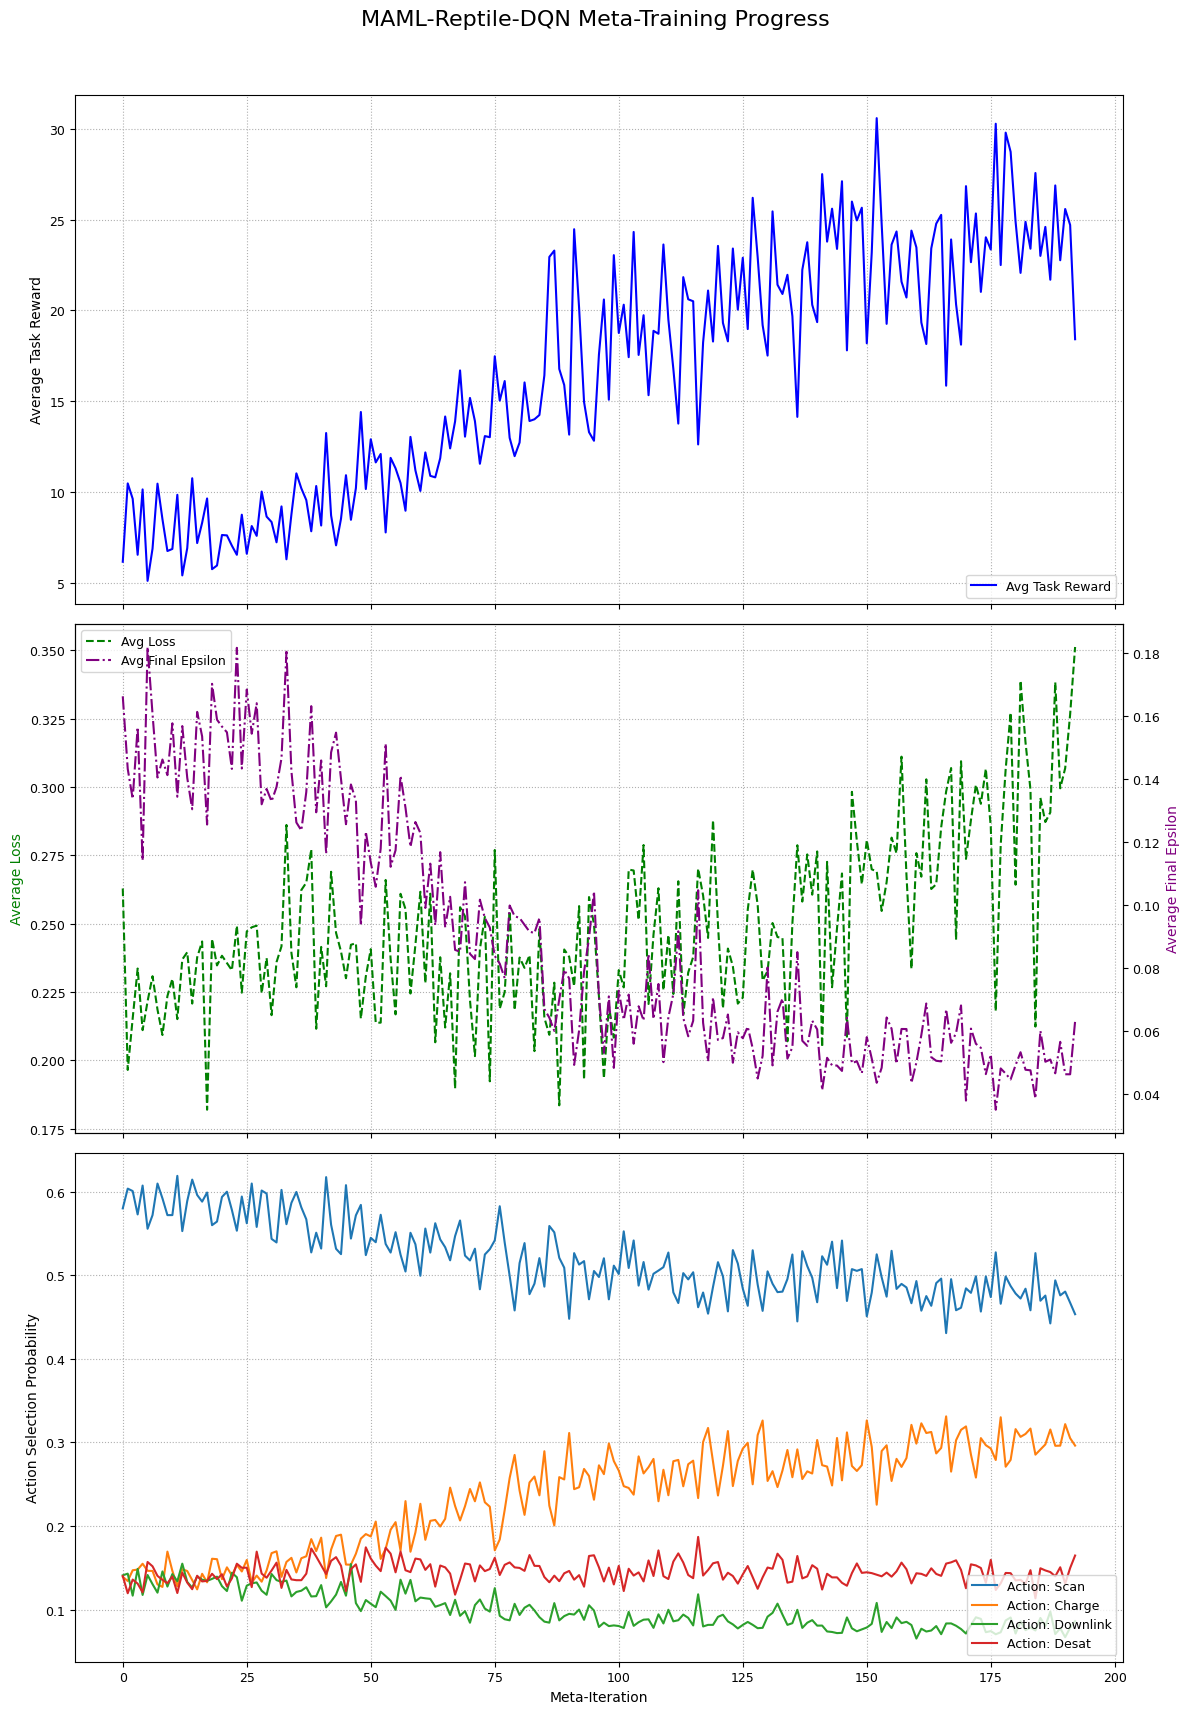

In [2]:
# MAML-Reptile_LEO_training.py
import gymnasium as gym
import traceback
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import copy
import os
import matplotlib.pyplot as plt

from bsk_rl.sim.world import BasicWorldModel, GroundStationWorldModel
from Basilisk.utilities import simIncludeGravBody, orbitalMotion, macros # Added macros for D2R if needed
from bsk_rl.sats.satellite import Satellite
from bsk_rl.obs.observations import SatProperties, Eclipse, Time
from bsk_rl.act.discrete_actions import Scan, Charge, Downlink, Desat
from bsk_rl.sim.fsw import ContinuousImagingFSWModel
from bsk_rl.data import ScanningTimeReward
from bsk_rl.sim import dyn
from bsk_rl.utils.functional import default_args
from bsk_rl import GeneralSatelliteTasking, scene, sats
from bsk_rl import obs # Already imported

# === Hyperparameters ===
# MAML/Meta-Learning Hyperparameters
NUM_META_ITERATIONS = 500
EARLY_STOPPING_PATIENCE = 60 # Number of iterations with no improvement to wait before stopping

META_LR = 1e-4  # Learning rate for the meta-optimizer (Adam for the meta-model's parameters directly)
K_SHOTS = 35      # Number of episodes for inner loop adaptation (meta-train)
TASKS_PER_META_BATCH = 4
META_STEP_SIZE = 0.05 # Reptile specific: step size for updating meta-parameters towards adapted parameters

# DQN/Inner Loop Hyperparameters
INNER_LR = 1e-3       # Learning rate for DQN in the inner loop
INNER_BATCH_SIZE = 32 # Batch size for DQN
REPLAY_CAPACITY = 1000 # Replay capacity PER TASK during inner loop
TARGET_UPDATE_FREQ = 100 # How often to update target network (in inner loop steps)
MAX_STEPS_PER_EPISODE = 600 # Max steps per episode
GAMMA = 0.99            # Discount factor for DQN
TAU = 0.01              # Soft update parameter for target network
EPSILON_START = 1.0
EPSILON_END = 0.02
EPSILON_DECAY = 300 # Epsilon decay for inner loop agents (might need tuning for K-shots)

# Reward
LEO_AVG_PERIOD = 5700
DURATION = 5 * LEO_AVG_PERIOD
PENALTY = -5
REWARD = 1.0 / (DURATION / 100)

# === Satellite and Dynamics =================================================================================================
class LEODynamicsModel(dyn.ContinuousImagingDynModel, dyn.GroundStationDynModel):
    @property
    def instrument_pointing_error(self) -> float:
        # DEBUG print included from previous step
        if np.linalg.norm(self.r_BN_P) < 1e-6:
            # print("DEBUG: r_BN_P is zero vector for instrument")
            return np.pi
        r_BN_P_unit = self.r_BN_P / np.linalg.norm(self.r_BN_P)
        c_hat_P = self.satellite.fsw.c_hat_P
        dot_prod = np.dot(-r_BN_P_unit, c_hat_P)
        clipped_dot_prod = np.clip(dot_prod, -1.0, 1.0)
        angle = np.arccos(clipped_dot_prod)
        return angle

    @property
    def solar_pointing_error(self) -> float:
        # DEBUG print included from previous step
        sun_msg = self.world.gravFactory.spiceObject.planetStateOutMsgs[self.world.sun_index].read()
        a_vec = sun_msg.PositionVector
        if np.linalg.norm(a_vec) < 1e-6:
            return np.pi
        a_hat_N = a_vec / np.linalg.norm(a_vec)
        NB = np.transpose(self.BN)
        nHat_N = NB @ self.satellite.sat_args["nHat_B"]
        dot_prod = np.dot(nHat_N, a_hat_N)
        clipped_dot_prod = np.clip(dot_prod, -1.0, 1.0)
        angle = np.arccos(clipped_dot_prod)
        return angle

class MetaScanningSatellite(sats.AccessSatellite):
    observation_spec = [
        SatProperties(
            dict(prop="storage_level_fraction"),
            dict(prop="battery_charge_fraction"),
            dict(prop="wheel_speeds_fraction"), # 3 values
            dict(prop="instrument_pointing_error", norm=np.pi),
            dict(prop="solar_pointing_error", norm=np.pi)
        ), 
        obs.OpportunityProperties(
            dict(prop="opportunity_open", norm=LEO_AVG_PERIOD),
            dict(prop="opportunity_close", norm=LEO_AVG_PERIOD),
            type="ground_station",
            n_ahead_observe=1,
        ),      
        Eclipse(norm=LEO_AVG_PERIOD),
        Time()
    ]
    action_spec = [Scan(180.0), Charge(120.0), Downlink(60.0), Desat(60.0)]
    dyn_type = LEODynamicsModel
    fsw_type = ContinuousImagingFSWModel


# === Env Construction ======================================================================================================
def get_default_leo_satellite_hardware_args(): 
    return {
        "dataStorageCapacity": 10000 * 8e6, # bits
        "storageInit": lambda: np.random.uniform(0.2, 0.6) * (10000 * 8e6),
        "instrumentBaudRate": 0.5 * 8e6, # bits/s
        "transmitterBaudRate": -50 * 8e6, # bits/s (negative for data removal)
        "batteryStorageCapacity": 400 * 3600, # Ws
        "storedCharge_Init": lambda: np.random.uniform(0.3, 1.0) * (200 * 3600), # Ws
        "basePowerDraw": -10.0, # W
        "instrumentPowerDraw": -30.0, # W
        "transmitterPowerDraw": -25.0, # W
        "thrusterPowerDraw": -80.0, # W
        "panelArea": 0.35, # m^2
        "imageAttErrorRequirement": np.deg2rad(0.1), # rad
        "imageRateErrorRequirement": np.deg2rad(0.1), # rad/s
        "disturbance_vector": lambda: np.random.normal(scale=0.0001, size=3), # Nm
        "maxWheelSpeed": 6000.0, # RPM
        "wheelSpeeds": lambda: np.random.uniform(-3000, 3000, 3), # RPM
        "desatAttitude": "nadir",
        "nHat_B": np.array([0.0, 0.0, 1.0]), # Body vector for solar panel pointing
    }

def get_default_leo_env_args(sat_hardware_args_dict, orbital_elements_dict):
    # sat_hardware_args_dict is the 'args' dictionary from sample_LEO_task_env_args
    
    elements_obj = orbitalMotion.ClassicElements()
    elements_obj.a = orbital_elements_dict["a"] * 1000  # km to m
    elements_obj.e = orbital_elements_dict["e"]
    elements_obj.i = np.deg2rad(orbital_elements_dict["i"])
    elements_obj.Omega = np.deg2rad(orbital_elements_dict["Omega"])
    elements_obj.omega = np.deg2rad(orbital_elements_dict["omega"])
    elements_obj.f = np.deg2rad(orbital_elements_dict["f"])    
    # Update the original sat_hardware_args_dict that will be used by the satellite
    sat_hardware_args_dict.update({
        "utc_init": "2025 JAN 01 00:00:00.0 (UTC)",
        "oe": elements_obj,
        "mu": orbital_elements_dict["mu"] * (1000**3) # km^3/s^2 to m^3/s^2
    })

    # Creates the satellite object after its full args dict is prepared
    sat_name = f"LEOScanner_Task_{orbital_elements_dict.get('task_id', random.randint(0, 10000))}"
    sat = MetaScanningSatellite(sat_name, sat_args=sat_hardware_args_dict) 
    return dict(
        satellites=[sat],
        world_args=dict(utc_init="2025 JAN 01 00:00:00.0 (UTC)"),
        scenario=scene.UniformNadirScanning(value_per_second=REWARD),
        rewarder=ScanningTimeReward(),
        sim_rate=1.0,
        max_step_duration=600.0,
        time_limit=DURATION,
        failure_penalty=PENALTY,
        terminate_on_time_limit=True,
        log_level="CRITICAL"
    )

# Makes sure sample_LEO_task_env_args calls this correctly:
def sample_LEO_task_env_args(): 
    args = get_default_leo_satellite_hardware_args()
    # ... (vary hardware in args) ...
    orbital_elements = {
        "a": 6371.0 + np.random.uniform(400, 700), 
        "e": np.random.uniform(0.0, 0.02),      
        "i": np.random.uniform(20, 98),         
        "Omega": np.random.uniform(0, 360),     
        "omega": np.random.uniform(0, 360),     
        "f": np.random.uniform(0, 360),         
        "mu": 398600.4418                        
    }
    return get_default_leo_env_args(args, orbital_elements)


# === DQN and Replay Buffer Classes =========================================================================================
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class SimpleReplayBuffer:
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQNNetwork(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, output_dim)

    def forward(self, x):
        if x.ndim == 3:
            x = x.squeeze(1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:

    def __init__(self, n_observations, n_actions, learning_rate=1e-4, gamma=0.99, tau=0.005,
                 epsilon_start=1.0, epsilon_end=0.02, epsilon_decay=300):
        self.n_actions = n_actions
        self.gamma = gamma
        self.tau = tau
        self.policy_net = DQNNetwork(n_observations, n_actions)
        self.target_net = DQNNetwork(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate, amsgrad=True)
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0 # This will be for the K-shot adaptation phase of each task
        self.n_observations = n_observations

    def select_action(self, state, evaluation_mode=False):
        # state is expected to be a flattened numpy array already
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                        np.exp(-1. * self.steps_done / self.epsilon_decay)
        if not evaluation_mode: # only increment steps if not in eval (e.g. during K-shot learning)
            self.steps_done += 1
        if evaluation_mode or random.random() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.n_actions)

    def learn(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return None
        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))

        state_batch_list = [torch.tensor(s, dtype=torch.float32) for s in batch.state] 
        state_batch = torch.stack(state_batch_list)
        action_batch = torch.tensor(batch.action, dtype=torch.long).view(-1, 1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        non_final_next_states_list = [torch.tensor(s, dtype=torch.float32) for s in batch.next_state if s is not None]
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        
        if non_final_next_states_list:
            non_final_next_states_tensor = torch.stack(non_final_next_states_list)
        else:
            non_final_next_states_tensor = torch.empty(0, self.n_observations, dtype=torch.float32)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch).squeeze(1)
        
        next_state_q_values = torch.zeros(batch_size, dtype=torch.float32)
        if non_final_next_states_tensor.shape[0] > 0:
            with torch.no_grad():
                next_state_q_values[non_final_mask] = self.target_net(non_final_next_states_tensor).max(1)[0]
        
        expected_q_values = reward_batch + (self.gamma * next_state_q_values)
        
        loss = nn.SmoothL1Loss()(state_action_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return loss.item()

    def update_target_network(self):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        self.target_net.load_state_dict(target_net_state_dict)

    def get_policy_net_params(self):
        return copy.deepcopy(self.policy_net.state_dict())

    def set_policy_net_params(self, state_dict):
        self.policy_net.load_state_dict(state_dict)


# === MAML (Reptile) Meta-Learning ===
class MAML_Reptile_DQN:
    def __init__(self, n_observations, n_actions, meta_lr=META_LR, inner_lr=INNER_LR,
                 k_shot_episodes_meta_train=K_SHOTS, inner_batch_size=INNER_BATCH_SIZE,
                 replay_capacity_per_task=REPLAY_CAPACITY, target_update_freq_inner=TARGET_UPDATE_FREQ,
                 max_steps_per_episode=MAX_STEPS_PER_EPISODE,
                 gamma=GAMMA, tau=TAU, epsilon_start=EPSILON_START, epsilon_end=EPSILON_END, epsilon_decay=EPSILON_DECAY):
        
        self.meta_model_agent = DQNAgent(n_observations, n_actions, learning_rate=meta_lr, gamma=gamma, tau=tau,
                                         epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_decay=epsilon_decay)
        # Store hyperparams for task-specific agents
        self.inner_lr = inner_lr
        self.k_shot_episodes_meta_train = k_shot_episodes_meta_train
        self.inner_batch_size = inner_batch_size
        self.replay_capacity_per_task = replay_capacity_per_task
        self.target_update_freq_inner = target_update_freq_inner
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.max_steps_per_episode = max_steps_per_episode
        self.gamma = gamma
        self.tau = tau
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Lists to store historical data for plotting >>>
        self.history = {
            "meta_iteration_avg_rewards": [],
            "meta_iteration_avg_loss": [],
            "meta_iteration_final_epsilon": [],
            "meta_iteration_action_distributions": []
        }
        
    def meta_train_on_leo(self, num_meta_iterations=NUM_META_ITERATIONS, 
                          tasks_per_meta_batch=TASKS_PER_META_BATCH, 
                          meta_step_size=META_STEP_SIZE,
                          early_stopping_patience=10): # <<< NEW: Early stopping parameter
        print("--- Starting Meta-Training on LEO Tasks (MAML-Reptile-DQN) ---")
        
        # <<< NEW: Early stopping variables >>>
        best_meta_reward = -np.inf
        epochs_no_improve = 0

        for meta_iter in range(num_meta_iterations):
            adapted_task_param_diffs = []
            batch_task_avg_rewards = []
            batch_task_avg_losses = []
            batch_task_final_epsilons = []
            batch_task_action_hist = []
    
            meta_weights_before_task_batch = self.meta_model_agent.get_policy_net_params()

            for task_idx in range(tasks_per_meta_batch):
                try:
                    env_args = sample_LEO_task_env_args()
                    env_args['satellites'][0].name = f"LEOScanner_Task{task_idx}_Iter{meta_iter}"
                    env = GeneralSatelliteTasking(**env_args)
                except Exception as e:
                    print(f"Failed to create LEO task {task_idx} in meta-iter {meta_iter+1}: {e}")
                    continue
    
                task_agent = DQNAgent(self.n_observations, self.n_actions, 
                                      learning_rate=self.inner_lr, gamma=self.gamma, tau=self.tau,
                                      epsilon_start=self.epsilon_start, epsilon_end=self.epsilon_end,
                                      epsilon_decay=self.epsilon_decay)
                task_agent.set_policy_net_params(meta_weights_before_task_batch)
                task_agent.target_net.load_state_dict(task_agent.policy_net.state_dict())
    
                task_buffer = SimpleReplayBuffer(self.replay_capacity_per_task)
                task_rewards_for_log = []
                task_losses_for_log = []
                task_actions_for_log = []
    
                #  Reset agent's step counter for epsilon decay for each new task adaptation >>>
                task_agent.steps_done = 0

                for episode in range(self.k_shot_episodes_meta_train):
                    state, _ = env.reset()
                    state = np.array(state, dtype=np.float32).flatten()
                    total_reward_this_episode = 0
    
                    for step in range(self.max_steps_per_episode):
                        action = task_agent.select_action(state)
                        task_actions_for_log.append(action)
                        
                        next_obs, reward, terminated, truncated, _ = env.step([action])
                        done = terminated or truncated
    
                        next_state_for_buffer = None if done else np.array(next_obs, dtype=np.float32).flatten()
                        task_buffer.push(state, action, next_state_for_buffer, reward, float(done))
                        
                        state = next_state_for_buffer
                        total_reward_this_episode += reward
    
                        loss_item = task_agent.learn(task_buffer, self.inner_batch_size)
                        if loss_item is not None:
                            task_losses_for_log.append(loss_item)
    
                        if task_agent.steps_done % self.target_update_freq_inner == 0:
                            task_agent.update_target_network()
    
                        if done:
                            break
                    task_rewards_for_log.append(total_reward_this_episode)
                
                if task_rewards_for_log:
                    adapted_task_params = task_agent.get_policy_net_params()
                    param_diff = {key: adapted_task_params[key] - meta_weights_before_task_batch[key] 
                                  for key in meta_weights_before_task_batch}
                    adapted_task_param_diffs.append(param_diff)
                    batch_task_avg_rewards.append(np.mean(task_rewards_for_log))
                    if task_losses_for_log:
                        batch_task_avg_losses.append(np.mean(task_losses_for_log))
                    
                    # Log final epsilon and action distribution for this task
                    final_epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                                    np.exp(-1. * task_agent.steps_done / self.epsilon_decay)
                    batch_task_final_epsilons.append(final_epsilon)
                    batch_task_action_hist.extend(task_actions_for_log)

                env.close()
                del env, task_agent, task_buffer
    
            # Meta-update
            if not adapted_task_param_diffs:
                print(f"[Meta-Iter {meta_iter+1}] No successful tasks in this meta-batch.")
                if self.history["meta_iteration_avg_rewards"]:
                    self.history["meta_iteration_avg_rewards"].append(self.history["meta_iteration_avg_rewards"][-1])
                    self.history["meta_iteration_avg_loss"].append(self.history["meta_iteration_avg_loss"][-1])
                    self.history["meta_iteration_final_epsilon"].append(self.history["meta_iteration_final_epsilon"][-1])
                    self.history["meta_iteration_action_distributions"].append(self.history["meta_iteration_action_distributions"][-1])
                continue
            
            new_meta_params = copy.deepcopy(meta_weights_before_task_batch)
            for key in new_meta_params:
                if adapted_task_param_diffs:
                    avg_diff_for_key = torch.stack([diff[key] for diff in adapted_task_param_diffs]).mean(dim=0)
                    new_meta_params[key] = meta_weights_before_task_batch[key] + meta_step_size * avg_diff_for_key
            
            self.meta_model_agent.set_policy_net_params(new_meta_params)
            self.meta_model_agent.target_net.load_state_dict(self.meta_model_agent.policy_net.state_dict())

            # Calculate and store metrics for this meta-iteration
            current_meta_avg_reward = np.mean(batch_task_avg_rewards)
            current_meta_avg_loss = np.mean(batch_task_avg_losses) if batch_task_avg_losses else 0
            current_meta_final_epsilon = np.mean(batch_task_final_epsilons)
            
            # Calculates action distribution for this meta-batch
            action_counts = np.bincount(batch_task_action_hist, minlength=self.n_actions)
            action_distribution = action_counts / np.sum(action_counts) if np.sum(action_counts) > 0 else np.zeros(self.n_actions)

            self.history["meta_iteration_avg_rewards"].append(current_meta_avg_reward)
            self.history["meta_iteration_avg_loss"].append(current_meta_avg_loss)
            self.history["meta_iteration_final_epsilon"].append(current_meta_final_epsilon)
            self.history["meta_iteration_action_distributions"].append(action_distribution)
            
            # Updated print statement 
            print(
                f"[Meta-Iter {meta_iter+1}/{num_meta_iterations}] "
                f"Avg Reward: {current_meta_avg_reward:.2f} | "
                f"Avg Loss: {current_meta_avg_loss:.4f} | "
                f"Avg Final Epsilon: {current_meta_final_epsilon:.3f} | "
                f"Action Dist: {[f'{p:.2f}' for p in action_distribution]}"
            )

            # <<< NEW: Early Stopping Check >>>
            if current_meta_avg_reward > best_meta_reward:
                best_meta_reward = current_meta_avg_reward
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= early_stopping_patience:
                print(f"\n--- Early stopping triggered after {epochs_no_improve} iterations with no improvement. ---")
                print(f"Best average reward achieved was: {best_meta_reward:.2f}")
                break  # Exit the main meta-training loop
    
        print("--- Meta-Training Finished ---")
        return self.history # Return the whole history dictionary
        

# === Determine Observation & Action Dimensions =============================================================================
def determine_obs_act_dims_for_maml():
    print("Determining observation and action space dimensions from a sample LEO task...")
    try:
        env_args = sample_LEO_task_env_args() 
        env = GeneralSatelliteTasking(**env_args)
        state, _ = env.reset()
        
        obs_dim = np.array(state, dtype=np.float32).flatten().shape[0]
        
        # Corrected way to get act_dim for Gymnasium environments
        if hasattr(env, "action_space") and hasattr(env.action_space, "n"):
            act_dim = env.action_space.n
        elif env.satellites and hasattr(env.satellites[0], "action_spec"): # Fallback for bsk_rl specific structure
            print("Warning: Using env.satellites[0].action_spec for act_dim.")
            act_dim = len(env.satellites[0].action_spec)
        else:
            print("Error: Could not determine act_dim. Defaulting to 4.")
            act_dim = 4
            
        env.close()
        del env
        print(f"Detected obs_dim={obs_dim}, act_dim={act_dim}")
        return obs_dim, act_dim
    except Exception as e:
        print(f"Error determining obs/act dims for MAML: {e}")
        import traceback # Make sure traceback is imported here or globally
        traceback.print_exc()
        print("Falling back to obs_dim=10, act_dim=4") 
        return 12, 4 # Fallback
        
# === Main Execution Block for MAML-Reptile-DQN Training ===============================================================================================
if __name__ == "__main__":
    n_observations, n_actions = determine_obs_act_dims_for_maml()

    print(f"\nInitializing MAML-Reptile-DQN agent for LEO meta-training (Obs: {n_observations}, Act: {n_actions})...")
    
    maml_dqn_agent = MAML_Reptile_DQN(
        n_observations=n_observations,
        n_actions=n_actions,
        meta_lr=META_LR,
        inner_lr=INNER_LR,
        k_shot_episodes_meta_train=K_SHOTS,
        inner_batch_size=INNER_BATCH_SIZE,
        replay_capacity_per_task=REPLAY_CAPACITY,
        target_update_freq_inner=TARGET_UPDATE_FREQ,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        gamma=GAMMA,
        tau=TAU,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY
    )

    training_history = maml_dqn_agent.meta_train_on_leo(
        num_meta_iterations=NUM_META_ITERATIONS,
        tasks_per_meta_batch=TASKS_PER_META_BATCH,
        meta_step_size=META_STEP_SIZE,
        early_stopping_patience=EARLY_STOPPING_PATIENCE # <<< Pass the new parameter
    )

    # Save final meta-model
    final_meta_model_path = f"maml_reptile_dqn_leo_meta_final_{NUM_META_ITERATIONS}_iters.pth"
    torch.save(maml_dqn_agent.meta_model_agent.policy_net.state_dict(), final_meta_model_path)
    print(f"Saved final meta-policy to {final_meta_model_path}")

    # Plotting logic
    try:
        # Create a figure with 3 subplots (3 rows, 1 column)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
        fig.suptitle('MAML-Reptile-DQN Meta-Training Progress', fontsize=16)

        # Plot 1: Average Reward
        ax1.plot(training_history["meta_iteration_avg_rewards"], label='Avg Task Reward', color='blue')
        ax1.set_ylabel("Average Task Reward")
        ax1.grid(True, linestyle=':')
        ax1.legend()
        
        # Plot 2: Average Loss and Epsilon
        ax2_twin = ax2.twinx()
        ax2.plot(training_history["meta_iteration_avg_loss"], label='Avg Loss', color='green', linestyle='--')
        ax2_twin.plot(training_history["meta_iteration_final_epsilon"], label='Avg Final Epsilon', color='purple', linestyle='-.')
        ax2.set_ylabel("Average Loss", color='green')
        ax2_twin.set_ylabel("Average Final Epsilon", color='purple')
        ax2.grid(True, linestyle=':')
        # Create legends for ax2
        lines, labels = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='best')

        # Plot 3: Action Distribution
        action_distributions = np.array(training_history["meta_iteration_action_distributions"])
        action_labels = ['Scan', 'Charge', 'Downlink', 'Desat']
        for i in range(n_actions):
            ax3.plot(action_distributions[:, i], label=f'Action: {action_labels[i]}')
        ax3.set_xlabel("Meta-Iteration")
        ax3.set_ylabel("Action Selection Probability")
        ax3.legend()
        ax3.grid(True, linestyle=':')

        fig.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to make room for suptitle
        
        plot_path = f"maml_reptile_dqn_leo_meta_plots_{NUM_META_ITERATIONS}_iters.png"
        plt.savefig(plot_path)
        print(f"Saved plots to {plot_path}")
        plt.show()

    except Exception as e:
        print(f"Plotting failed: {e}")

# LOAD MAML Lunar DQN

# Lunar adaptation and comparison script

This script evaluates the adaptability of the meta-learned policy from maml_leo_training.py by applying it to a new, challenging Lunar orbit environment. It compares three scenarios: (1) the zero-shot performance of the pre-trained MAML policy on the lunar task, (2) the performance after few-shot fine-tuning on the lunar environment, and (3) the performance of a new DQN agent trained from scratch on the same lunar task. Using the Basilisk framework, it simulates a satellite in lunar orbit with specific orbital and hardware configurations. The script fine-tunes the meta-learned policy with a small number of episodes and contrasts its performance against the scratch-trained agent, demonstrating the efficiency of meta-learning for rapid adaptation. Results are summarized with average rewards and visualized in a plot comparing adaptation and scratch training progress.

Narrative Hook for Jupyter Notebook:

"What happens when a satellite trained for Earth’s orbit is sent to the Moon? This script tests the power of our meta-learned satellite controller by throwing it into a lunar mission. We’ll see how well it performs right out of the gate (zero-shot), how quickly it can adapt with minimal fine-tuning, and how it stacks up against a brand-new agent trained from scratch. Through realistic simulations and insightful visualizations, we’ll uncover whether meta-learning truly gives our satellite a head start in this extraterrestrial challenge!"

Setting up Lunar adaptation environment...
Lunar Environment: Obs Dim=12, Act Dim=4
Initial Observation: [ 3.68260847e-01  3.06444681e-01 -3.68060331e-01 -2.07681317e-01
 -2.64257831e-01  4.89950137e-01  5.75030685e-01  0.00000000e+00
  1.81208838e-02  1.75438596e-04  1.75438596e-04  0.00000000e+00]

Loading meta-trained policy from maml_reptile_dqn_leo_meta_final_350_iters.pth...
Meta-policy loaded. Input dim: 12, Output dim: 4

--- Evaluating meta-policy on Lunar task (zero-shot)... ---
Average reward before adaptation (zero-shot): 32.37

--- Starting Few-Shot Adaptation for 20 episodes... ---
Adaptation Episode 1/20 | Reward: 33.62 | Steps: 60 | Actions: [0.45, 0.4166666666666667, 0.016666666666666666, 0.11666666666666667] | Avg Q: 6.73
Adaptation Episode 2/20 | Reward: 37.81 | Steps: 60 | Actions: [0.4, 0.4, 0.016666666666666666, 0.18333333333333332] | Avg Q: 5.60
Adaptation Episode 3/20 | Reward: 30.57 | Steps: 60 | Actions: [0.45, 0.45, 0.0, 0.1] | Avg Q: 4.51
Adaptation Episode 

/tmp/ipykernel_274014/2114408573.py:535: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([zero_shot_rewards, adapted_rewards, scratch_eval_rewards], labels=['Zero-Shot', 'Adapted', 'Scratch'])


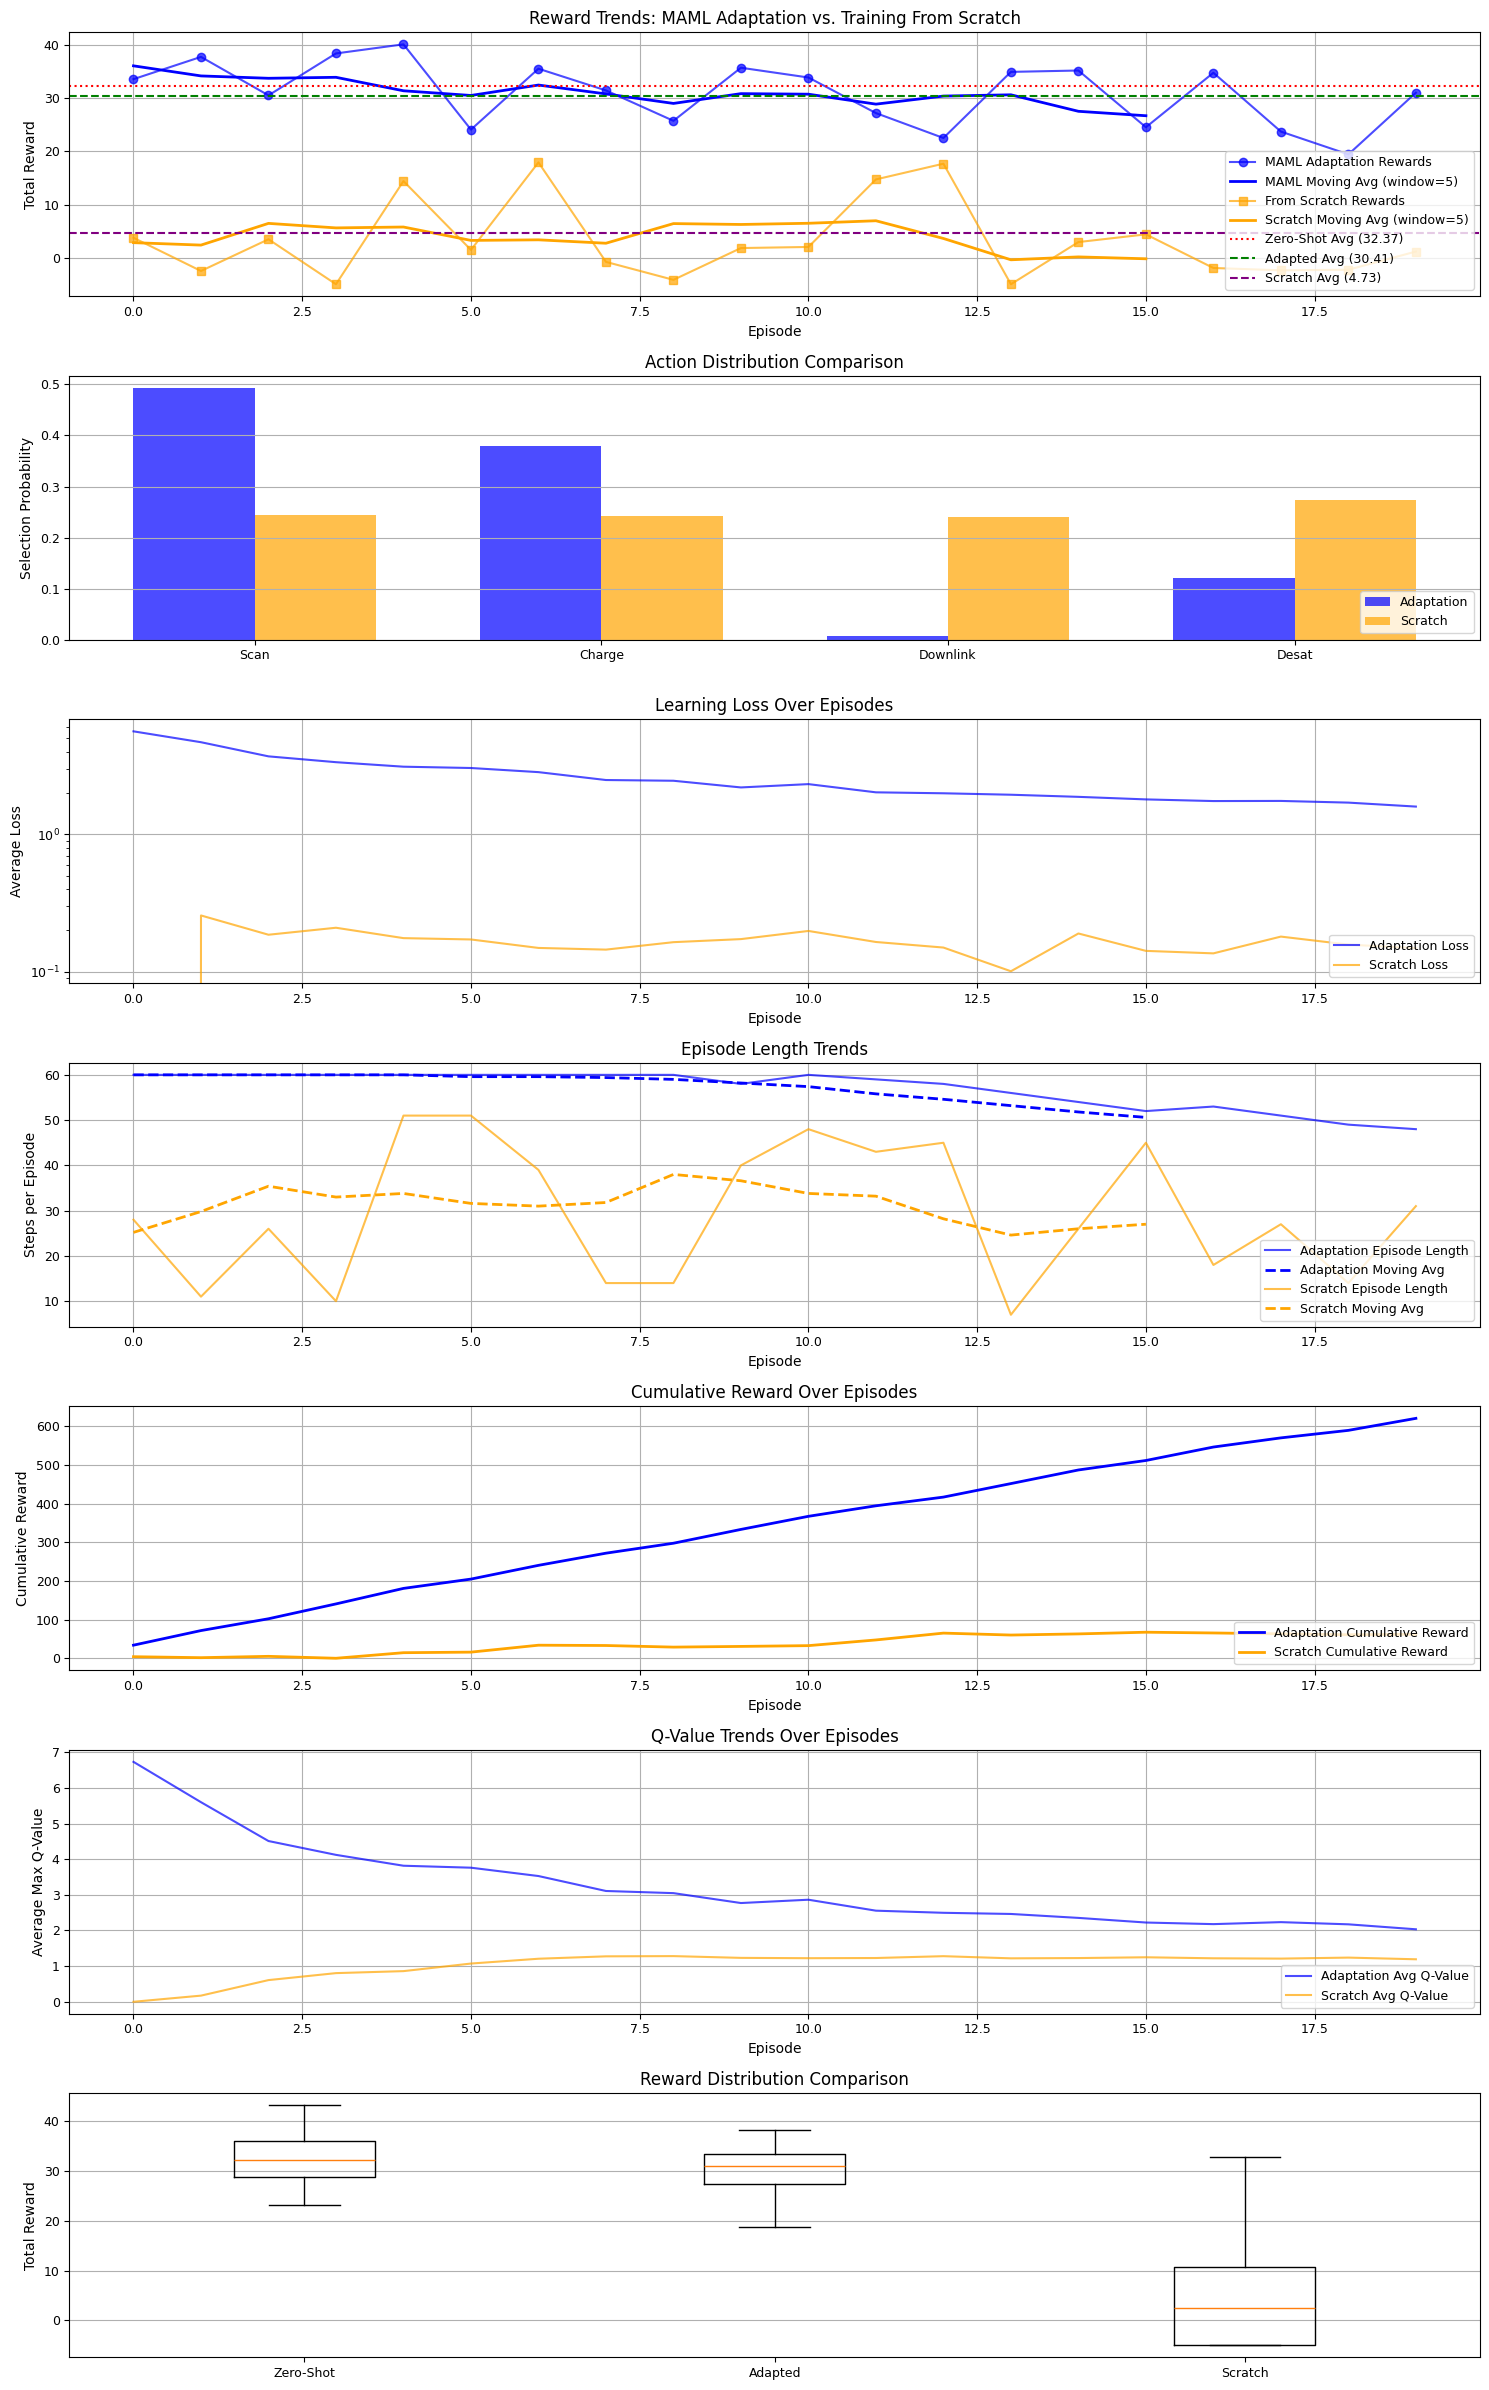


--- Comparison Complete ---
Zero-Shot Performance (MAML Policy): 32.37
From-Scratch Performance (Random Init): 4.73
Few-Shot Adapted Performance (MAML Fine-Tuned): 30.41


In [17]:
# === Imports ===
import gymnasium as gym
import traceback
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import copy
import os
import matplotlib.pyplot as plt

# BSK Imports
from bsk_rl.sim.world import BasicWorldModel, GroundStationWorldModel
from Basilisk.utilities import simIncludeGravBody, orbitalMotion
from bsk_rl.sats.satellite import Satellite
from bsk_rl.obs.observations import SatProperties, Eclipse, Time
from bsk_rl.act.discrete_actions import Scan, Charge, Downlink, Desat
from bsk_rl.sim.fsw import ContinuousImagingFSWModel
from bsk_rl.data import ScanningTimeReward
from bsk_rl.sim import dyn
from bsk_rl.utils.functional import default_args
from bsk_rl import GeneralSatelliteTasking, scene, sats, obs

# === Hyperparameters ===
NUM_ADAPTATION_EPISODES = 20
INNER_BATCH_SIZE = 32
REPLAY_CAPACITY = 10000
TARGET_UPDATE_FREQ = 100
MAX_STEPS_PER_EPISODE = 600
GAMMA = 0.99
TAU = 0.005
ADAPT_LR = 5e-6
ADAPT_EPSILON_START = 0.02
ADAPT_EPSILON_END = 0.01
ADAPT_EPSILON_DECAY = 15000
SCRATCH_LR = 1e-4
SCRATCH_EPSILON_START = 1.0
SCRATCH_EPSILON_END = 0.02
SCRATCH_EPSILON_DECAY = 10000
NUM_EVAL_EPISODES = 20
LEO_AVG_PERIOD = 5700
LUNAR_AVG_PERIOD = 7200
DURATION = 5 * LUNAR_AVG_PERIOD
PENALTY = -5
REWARD = 1.0 / (DURATION / 100)

# === Universal Satellite & Environment Definition ===
class LEODynamicsModel(dyn.ContinuousImagingDynModel, dyn.GroundStationDynModel):
    @property
    def instrument_pointing_error(self) -> float:
        if np.linalg.norm(self.r_BN_P) < 1e-6:
            return np.pi
        r_BN_P_unit = self.r_BN_P / np.linalg.norm(self.r_BN_P)
        c_hat_P = self.satellite.fsw.c_hat_P
        dot_prod = np.dot(-r_BN_P_unit, c_hat_P)
        return np.arccos(np.clip(dot_prod, -1.0, 1.0))

    @property
    def solar_pointing_error(self) -> float:
        sun_msg = self.world.gravFactory.spiceObject.planetStateOutMsgs[self.world.sun_index].read()
        a_vec = sun_msg.PositionVector
        if np.linalg.norm(a_vec) < 1e-6:
            return np.pi
        a_hat_N = a_vec / np.linalg.norm(a_vec)
        NB = np.transpose(self.BN)
        nHat_N = NB @ self.satellite.sat_args["nHat_B"]
        dot_prod = np.dot(nHat_N, a_hat_N)
        return np.arccos(np.clip(dot_prod, -1.0, 1.0))

class MetaScanningSatellite(sats.AccessSatellite):
    observation_spec = [
        SatProperties(
            dict(prop="storage_level_fraction"),
            dict(prop="battery_charge_fraction"),
            dict(prop="wheel_speeds_fraction"),
            dict(prop="instrument_pointing_error", norm=np.pi),
            dict(prop="solar_pointing_error", norm=np.pi)
        ),
        obs.OpportunityProperties(
            dict(prop="opportunity_open", norm=LEO_AVG_PERIOD),
            dict(prop="opportunity_close", norm=LEO_AVG_PERIOD),
            type="ground_station",
            n_ahead_observe=1,
        ),
        Eclipse(norm=LEO_AVG_PERIOD),
        Time()
    ]
    action_spec = [Scan(180.0), Charge(120.0), Downlink(60.0), Desat(60.0)]
    dyn_type = LEODynamicsModel
    fsw_type = ContinuousImagingFSWModel

def get_default_satellite_hardware_args():
    return {
        "dataStorageCapacity": 10000 * 8e6,
        "storageInit": lambda: np.random.uniform(0.2, 0.6) * (10000 * 8e6),
        "instrumentBaudRate": 0.5 * 8e6,
        "transmitterBaudRate": -50 * 8e6,
        "batteryStorageCapacity": 400 * 3600,
        "storedCharge_Init": lambda: np.random.uniform(0.3, 1.0) * (200 * 3600),
        "basePowerDraw": -10.0,
        "instrumentPowerDraw": -30.0,
        "transmitterPowerDraw": -25.0,
        "thrusterPowerDraw": -80.0,
        "panelArea": 0.35,
        "imageAttErrorRequirement": np.deg2rad(0.1),
        "imageRateErrorRequirement": np.deg2rad(0.1),
        "disturbance_vector": lambda: np.random.normal(scale=0.0001, size=3),
        "maxWheelSpeed": 6000.0,
        "wheelSpeeds": lambda: np.random.uniform(-3000, 3000, 3),
        "desatAttitude": "nadir",
        "nHat_B": np.array([0.0, 0.0, 1.0]),
    }

def get_lunar_adaptation_env():
    hardware_args = get_default_satellite_hardware_args()
    lunar_orbit = {
        "a": orbitalMotion.REQ_MOON + 100,
        "e": 0.0,
        "i": 45.0,
        "Omega": 0.0,
        "omega": 0.0,
        "f": 0.0,
        "mu": orbitalMotion.MU_MOON,
    }
    elements_obj = orbitalMotion.ClassicElements()
    elements_obj.a = lunar_orbit["a"] * 1000
    elements_obj.e = lunar_orbit["e"]
    elements_obj.i = np.deg2rad(lunar_orbit["i"])
    elements_obj.Omega = np.deg2rad(lunar_orbit["Omega"])
    elements_obj.omega = np.deg2rad(lunar_orbit["omega"])
    elements_obj.f = np.deg2rad(lunar_orbit["f"])
    hardware_args.update({
        "oe": elements_obj,
        "mu": lunar_orbit["mu"] * 1e9
    })
    sat = MetaScanningSatellite("LunarAdapter", sat_args=hardware_args)
    return GeneralSatelliteTasking(
        satellites=[sat],
        world_args=dict(utc_init="2025 JAN 01 00:00:00.0 (UTC)"),
        scenario=scene.UniformNadirScanning(value_per_second=REWARD),
        rewarder=ScanningTimeReward(),
        sim_rate=1.0,
        max_step_duration=600.0,
        time_limit=DURATION,
        failure_penalty=PENALTY,
        terminate_on_time_limit=True,
        log_level="CRITICAL"
    )

# === Observation Normalization ===
def normalize_observations(state, use_normalization=True):
    if not use_normalization:
        return state
    state = np.array(state)
    scale = LEO_AVG_PERIOD / LUNAR_AVG_PERIOD
    state[5:8] *= scale  # opportunity_open, opportunity_close, Eclipse
    return state

# === DQN and Replay Buffer Classes ===
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class SimpleReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, output_dim)
    def forward(self, x):
        if x.ndim == 3:
            x = x.squeeze(1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQNAgent:
    def __init__(self, n_observations, n_actions, **kwargs):
        self.n_actions = n_actions
        self.n_observations = n_observations
        self.gamma = kwargs.get("gamma", 0.99)
        self.tau = kwargs.get("tau", 0.005)
        self.policy_net = DQNNetwork(n_observations, n_actions)
        self.target_net = DQNNetwork(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=kwargs.get("learning_rate", 1e-4), amsgrad=True)
        self.epsilon_start = kwargs.get("epsilon_start", 1.0)
        self.epsilon_end = kwargs.get("epsilon_end", 0.02)
        self.epsilon_decay = kwargs.get("epsilon_decay", 300)
        self.steps_done = 0
    def select_action(self, state, evaluation_mode=False):
        eps_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-1. * self.steps_done / self.epsilon_decay)
        if not evaluation_mode:
            self.steps_done += 1
        if evaluation_mode or random.random() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0)
                return self.policy_net(state_tensor).max(1)[1].item()
        else:
            return random.randrange(self.n_actions)
    def learn(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return None, None
        transitions = replay_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        state_batch = torch.stack([torch.tensor(s, dtype=torch.float32) for s in batch.state])
        action_batch = torch.tensor(batch.action, dtype=torch.long).view(-1, 1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        if any(s is not None for s in batch.next_state):
            non_final_next_states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in batch.next_state if s is not None])
            state_action_values = self.policy_net(state_batch).gather(1, action_batch)
            next_state_values = torch.zeros(batch_size)
            with torch.no_grad():
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
            expected_state_action_values = (next_state_values * self.gamma) + reward_batch
            loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
            self.optimizer.step()
            max_q = self.policy_net(state_batch).max(1)[0].mean().item()
            return loss.item(), max_q
        return None, None
    def update_target_network(self):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + target_net_state_dict[key] * (1 - self.tau)
        self.target_net.load_state_dict(target_net_state_dict)
    def set_policy_net_params(self, state_dict):
        self.policy_net.load_state_dict(state_dict)

def evaluate_agent(env, agent, num_episodes, use_normalization=True):
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state = normalize_observations(np.array(state[0]).flatten(), use_normalization)
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state, evaluation_mode=True)
            next_obs, reward, terminated, truncated, _ = env.step([action])
            done = terminated or truncated
            state = normalize_observations(np.array(next_obs[0]).flatten(), use_normalization) if not done else None
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards), total_rewards

# === Main Execution Block ===
if __name__ == "__main__":
    # --- Step 0: Setup ---
    print("Setting up Lunar adaptation environment...")
    lunar_env = get_lunar_adaptation_env()
    observation, info = lunar_env.reset()
    n_observations = np.array(observation[0]).flatten().shape[0]
    n_actions = lunar_env.satellites[0].action_space.n
    print(f"Lunar Environment: Obs Dim={n_observations}, Act Dim={n_actions}")
    print(f"Initial Observation: {observation[0]}")
    use_normalization = True
    META_MODEL_PATH = "maml_reptile_dqn_leo_meta_final_350_iters.pth"
    if not os.path.exists(META_MODEL_PATH):
        raise FileNotFoundError(
            f"Meta-trained model not found at {META_MODEL_PATH}."
        )

    # --- Step 1: Initialize Agent with Meta-Learned Weights ---
    lunar_agent = DQNAgent(
        n_observations,
        n_actions,
        learning_rate=ADAPT_LR,
        gamma=GAMMA,
        tau=TAU,
        epsilon_start=ADAPT_EPSILON_START,
        epsilon_end=ADAPT_EPSILON_END,
        epsilon_decay=ADAPT_EPSILON_DECAY
    )
    print(f"\nLoading meta-trained policy from {META_MODEL_PATH}...")
    try:
        meta_weights = torch.load(META_MODEL_PATH)
        lunar_agent.set_policy_net_params(meta_weights)
        lunar_agent.update_target_network()
        print(f"Meta-policy loaded. Input dim: {lunar_agent.n_observations}, Output dim: {lunar_agent.n_actions}")
    except Exception as e:
        print(f"Error loading meta-policy: {e}")
        raise

    # --- Step 2: Evaluate Performance BEFORE Adaptation ---
    print("\n--- Evaluating meta-policy on Lunar task (zero-shot)... ---")
    zero_shot_performance, zero_shot_rewards = evaluate_agent(lunar_env, lunar_agent, NUM_EVAL_EPISODES, use_normalization)
    print(f"Average reward before adaptation (zero-shot): {zero_shot_performance:.2f}")

    # --- Step 3: Few-Shot Adaptation (Fine-Tuning) ---
    print(f"\n--- Starting Few-Shot Adaptation for {NUM_ADAPTATION_EPISODES} episodes... ---")
    replay_buffer = SimpleReplayBuffer(REPLAY_CAPACITY)
    adaptation_rewards = []
    adaptation_losses = []
    adaptation_actions = []
    adaptation_episode_lengths = []
    adaptation_q_values = []
    for episode in range(NUM_ADAPTATION_EPISODES):
        state, _ = lunar_env.reset()
        state = normalize_observations(np.array(state[0]).flatten(), use_normalization)
        episode_reward = 0
        episode_actions = []
        episode_losses = []
        episode_q_values = []
        step_count = 0
        for step in range(MAX_STEPS_PER_EPISODE):
            action = lunar_agent.select_action(state)
            episode_actions.append(action)
            next_obs, reward, terminated, truncated, _ = lunar_env.step([action])
            done = terminated or truncated
            next_state = None if done else normalize_observations(np.array(next_obs[0]).flatten(), use_normalization)
            replay_buffer.push(state, action, next_state, reward, float(done))
            state = next_state
            episode_reward += reward
            step_count += 1
            loss, max_q = lunar_agent.learn(replay_buffer, INNER_BATCH_SIZE)
            if loss is not None:
                episode_losses.append(loss)
                episode_q_values.append(max_q)
            if lunar_agent.steps_done % TARGET_UPDATE_FREQ == 0:
                lunar_agent.update_target_network()
            if done:
                break
        adaptation_rewards.append(episode_reward)
        adaptation_actions.extend(episode_actions)
        adaptation_episode_lengths.append(step_count)
        adaptation_losses.append(np.mean(episode_losses) if episode_losses else 0.0)
        adaptation_q_values.append(np.mean(episode_q_values) if episode_q_values else 0.0)
        action_counts = np.bincount(episode_actions, minlength=n_actions)
        action_dist = action_counts / np.sum(action_counts) if np.sum(action_counts) > 0 else np.zeros(n_actions)
        print(f"Adaptation Episode {episode + 1}/{NUM_ADAPTATION_EPISODES} | Reward: {episode_reward:.2f} | Steps: {step_count} | Actions: {action_dist.tolist()} | Avg Q: {adaptation_q_values[-1]:.2f}")

    # --- Step 4: Evaluate Performance AFTER Adaptation ---
    print("\n--- Evaluating adapted policy on Lunar task... ---")
    adapted_performance, adapted_rewards = evaluate_agent(lunar_env, lunar_agent, NUM_EVAL_EPISODES, use_normalization)
    print(f"Average reward after adaptation: {adapted_performance:.2f}")

    # --- Step 5: Train a New Agent From Scratch ---
    print(f"\n--- Training a new agent from scratch for {NUM_ADAPTATION_EPISODES} episodes... ---")
    scratch_agent = DQNAgent(
        n_observations,
        n_actions,
        learning_rate=SCRATCH_LR,
        gamma=GAMMA,
        tau=TAU,
        epsilon_start=SCRATCH_EPSILON_START,
        epsilon_end=SCRATCH_EPSILON_END,
        epsilon_decay=SCRATCH_EPSILON_DECAY
    )
    scratch_replay_buffer = SimpleReplayBuffer(REPLAY_CAPACITY)
    scratch_rewards = []
    scratch_losses = []
    scratch_actions = []
    scratch_episode_lengths = []
    scratch_q_values = []
    for episode in range(NUM_ADAPTATION_EPISODES):
        state, _ = lunar_env.reset()
        state = normalize_observations(np.array(state[0]).flatten(), use_normalization)
        episode_reward = 0
        episode_actions = []
        episode_losses = []
        episode_q_values = []
        step_count = 0
        for step in range(MAX_STEPS_PER_EPISODE):
            action = scratch_agent.select_action(state)
            episode_actions.append(action)
            next_obs, reward, terminated, truncated, _ = lunar_env.step([action])
            done = terminated or truncated
            next_state = None if done else normalize_observations(np.array(next_obs[0]).flatten(), use_normalization)
            scratch_replay_buffer.push(state, action, next_state, reward, float(done))
            state = next_state
            episode_reward += reward
            step_count += 1
            loss, max_q = scratch_agent.learn(scratch_replay_buffer, INNER_BATCH_SIZE)
            if loss is not None:
                episode_losses.append(loss)
                episode_q_values.append(max_q)
            if scratch_agent.steps_done % TARGET_UPDATE_FREQ == 0:
                scratch_agent.update_target_network()
            if done:
                break
        scratch_rewards.append(episode_reward)
        scratch_actions.extend(episode_actions)
        scratch_episode_lengths.append(step_count)
        scratch_losses.append(np.mean(episode_losses) if episode_losses else 0.0)
        scratch_q_values.append(np.mean(episode_q_values) if episode_q_values else 0.0)
        action_counts = np.bincount(episode_actions, minlength=n_actions)
        action_dist = action_counts / np.sum(action_counts) if np.sum(action_counts) > 0 else np.zeros(n_actions)
        print(f"Scratch Training Episode {episode + 1}/{NUM_ADAPTATION_EPISODES} | Reward: {episode_reward:.2f} | Steps: {step_count} | Actions: {action_dist.tolist()} | Avg Q: {scratch_q_values[-1]:.2f}")

    # --- Step 6: Evaluate the "From Scratch" Agent ---
    print("\n--- Evaluating agent trained from scratch... ---")
    scratch_performance, scratch_eval_rewards = evaluate_agent(lunar_env, scratch_agent, NUM_EVAL_EPISODES, use_normalization)
    print(f"Average reward for agent trained from scratch: {scratch_performance:.2f}")

    # --- Step 7: Compute and Print Additional Metrics ---
    print("\n--- Detailed Performance Analysis ---")
    # Reward Statistics
    print("\nAdaptation Reward Statistics:")
    print(f"- Min: {np.min(adaptation_rewards):.2f}")
    print(f"- Max: {np.max(adaptation_rewards):.2f}")
    print(f"- Mean: {np.mean(adaptation_rewards):.2f}")
    print(f"- Std Dev: {np.std(adaptation_rewards):.2f}")
    print("\nScratch Reward Statistics:")
    print(f"- Min: {np.min(scratch_rewards):.2f}")
    print(f"- Max: {np.max(scratch_rewards):.2f}")
    print(f"- Mean: {np.mean(scratch_rewards):.2f}")
    print(f"- Std Dev: {np.std(scratch_rewards):.2f}")

    # Action Distribution
    adapt_action_counts = np.bincount(adaptation_actions, minlength=n_actions)
    adapt_action_dist = adapt_action_counts / np.sum(adapt_action_counts) if np.sum(adapt_action_counts) > 0 else np.zeros(n_actions)
    scratch_action_counts = np.bincount(scratch_actions, minlength=n_actions)
    scratch_action_dist = scratch_action_counts / np.sum(scratch_action_counts) if np.sum(scratch_action_counts) > 0 else np.zeros(n_actions)
    action_labels = ['Scan', 'Charge', 'Downlink', 'Desat']
    print("\nAdaptation Action Distribution:")
    for label, prob in zip(action_labels, adapt_action_dist):
        print(f"- {label}: {prob*100:.1f}%")
    print("\nScratch Action Distribution:")
    for label, prob in zip(action_labels, scratch_action_dist):
        print(f"- {label}: {prob*100:.1f}%")

    # Average Loss and Q-Values
    print("\nLearning Stability:")
    print(f"Average Adaptation Loss: {np.mean([l for l in adaptation_losses if l > 0]):.4f}")
    print(f"Average Scratch Loss: {np.mean([l for l in scratch_losses if l > 0]):.4f}")
    print(f"Average Adaptation Q-Value: {np.mean([q for q in adaptation_q_values if q > 0]):.2f}")
    print(f"Average Scratch Q-Value: {np.mean([q for q in scratch_q_values if q > 0]):.2f}")

    # Episode Lengths
    print("\nEpisode Lengths:")
    print(f"Average Episode Length (Adaptation): {np.mean(adaptation_episode_lengths):.1f} steps")
    print(f"Average Episode Length (Scratch): {np.mean(scratch_episode_lengths):.1f} steps")

    # Performance Improvement
    print("\nPerformance Improvement:")
    adapt_vs_zero = ((adapted_performance - zero_shot_performance) / zero_shot_performance * 100) if zero_shot_performance != 0 else float('inf')
    adapt_vs_scratch = ((adapted_performance - scratch_performance) / scratch_performance * 100) if scratch_performance != 0 else float('inf')
    print(f"- Adapted vs. Zero-Shot: {adapt_vs_zero:+.1f}%")
    print(f"- Adapted vs. Scratch: {adapt_vs_scratch:+.1f}%")

    # --- Step 8: Enhanced Plotting ---
    def moving_average(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(15, 24))
    
    # Reward Plot with Moving Average
    plt.subplot(7, 1, 1)
    plt.plot(adaptation_rewards, 'o-', label='MAML Adaptation Rewards', alpha=0.7, color='blue')
    plt.plot(moving_average(adaptation_rewards), 'b-', label='MAML Moving Avg (window=5)', linewidth=2)
    plt.plot(scratch_rewards, 's-', label='From Scratch Rewards', alpha=0.7, color='orange')
    plt.plot(moving_average(scratch_rewards), 'orange', label='Scratch Moving Avg (window=5)', linewidth=2)
    plt.axhline(y=zero_shot_performance, color='red', linestyle=':', label=f'Zero-Shot Avg ({zero_shot_performance:.2f})')
    plt.axhline(y=adapted_performance, color='green', linestyle='--', label=f'Adapted Avg ({adapted_performance:.2f})')
    plt.axhline(y=scratch_performance, color='purple', linestyle='--', label=f'Scratch Avg ({scratch_performance:.2f})')
    plt.title("Reward Trends: MAML Adaptation vs. Training From Scratch")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)

    # Action Distribution Plot
    plt.subplot(7, 1, 2)
    x = np.arange(len(action_labels))
    width = 0.35
    plt.bar(x - width/2, adapt_action_dist, width, label='Adaptation', color='blue', alpha=0.7)
    plt.bar(x + width/2, scratch_action_dist, width, label='Scratch', color='orange', alpha=0.7)
    plt.xticks(x, action_labels)
    plt.title("Action Distribution Comparison")
    plt.ylabel("Selection Probability")
    plt.legend()
    plt.grid(True, axis='y')

    # Loss Plot
    plt.subplot(7, 1, 3)
    plt.plot(adaptation_losses, 'b-', label='Adaptation Loss', alpha=0.7)
    plt.plot(scratch_losses, 'orange', label='Scratch Loss', alpha=0.7)
    plt.title("Learning Loss Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Average Loss")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # Episode Length Plot
    plt.subplot(7, 1, 4)
    plt.plot(adaptation_episode_lengths, color='blue', label='Adaptation Episode Length', alpha=0.7)
    plt.plot(moving_average(adaptation_episode_lengths), color='blue', linestyle='--', label='Adaptation Moving Avg', linewidth=2)
    plt.plot(scratch_episode_lengths, color='orange', label='Scratch Episode Length', alpha=0.7)
    plt.plot(moving_average(scratch_episode_lengths), color='orange', linestyle='--', label='Scratch Moving Avg', linewidth=2)
    plt.title("Episode Length Trends")
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.legend()
    plt.grid(True)

    # Cumulative Reward Plot
    plt.subplot(7, 1, 5)
    plt.plot(np.cumsum(adaptation_rewards), 'b-', label='Adaptation Cumulative Reward', linewidth=2)
    plt.plot(np.cumsum(scratch_rewards), 'orange', label='Scratch Cumulative Reward', linewidth=2)
    plt.title("Cumulative Reward Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.grid(True)

    # Q-Value Plot
    plt.subplot(7, 1, 6)
    plt.plot(adaptation_q_values, 'b-', label='Adaptation Avg Q-Value', alpha=0.7)
    plt.plot(scratch_q_values, 'orange', label='Scratch Avg Q-Value', alpha=0.7)
    plt.title("Q-Value Trends Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Average Max Q-Value")
    plt.legend()
    plt.grid(True)

    # Box Plot
    plt.subplot(7, 1, 7)
    plt.boxplot([zero_shot_rewards, adapted_rewards, scratch_eval_rewards], labels=['Zero-Shot', 'Adapted', 'Scratch'])
    plt.title("Reward Distribution Comparison")
    plt.ylabel("Total Reward")
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig("lunar_adaptation_analysis.png")
    plt.show()

    # --- Step 9: Final Results Summary ---
    print("\n--- Comparison Complete ---")
    print(f"Zero-Shot Performance (MAML Policy): {zero_shot_performance:.2f}")
    print(f"From-Scratch Performance (Random Init): {scratch_performance:.2f}")
    print(f"Few-Shot Adapted Performance (MAML Fine-Tuned): {adapted_performance:.2f}")

    lunar_env.close()